This python script uses a neural network to predict sequences of optical signals.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, LSTM, Flatten, GlobalMaxPool1D
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model
import h5py

## Explore the dataset

In [3]:
df = pd.read_csv('Optical_Signal.dat',sep='\t')
df.head()

,t,I
0,0.038148,0.027355
1,0.114443,0.032728
2,0.190738,0.045104
3,0.267033,0.068821
4,0.343328,0.110740


In [4]:
df.shape

(32768, 2)

In [5]:
df = df.iloc[0:5000,:]

In [6]:
t = df.iloc[:,0] #time
I = df.iloc[:,1]/df.iloc[:,1].max() #intensity

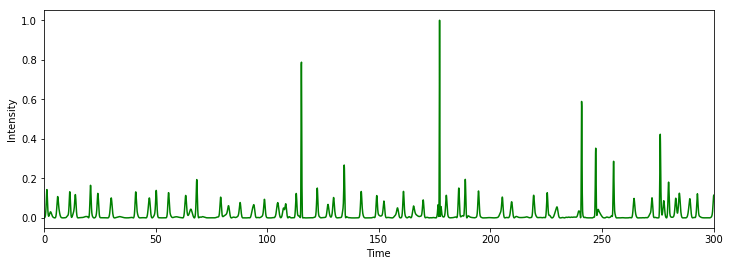

In [7]:
plt.figure(figsize=(12.0,4.0))
plt.plot(t, I, c='g')
plt.ylabel('Intensity')
plt.xlabel('Time')
plt.xlim([0,300])
plt.show()

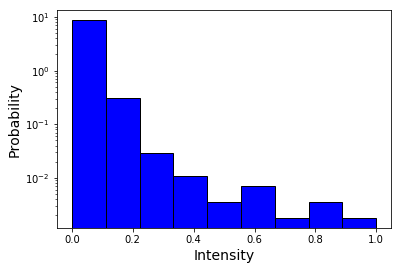

In [8]:
plt.hist(I, bins=np.linspace(0,1,10), color='blue', ec='black', normed=True)
plt.xlabel('Intensity', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.yscale('log')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Divide signal in smaller sequences 

In [9]:
# time step
dt = t[1]-t[0]
dt

0.076295

In [10]:
# number of points to look back
look_back = 100#int(10/dt)
look_back

100

In [11]:
# crete sequences and next
y_seq = []
y_next = [] 

for i in range(len(I)-look_back-1):
    y_seq.append(I[i:(i+look_back)])
    y_next.append(I[i+look_back])

In [12]:
y_seq = np.array(y_seq)
y_seq.shape

(4899, 100)

In [13]:
y_next = np.array(y_next)
y_next.shape

(4899,)

## Split into train and test sets

In [14]:
train_size = 3000

In [15]:
y_seq_train = y_seq[:train_size,:]
y_seq_val = y_seq[train_size:train_size+1000,:]
y_seq_test = y_seq[train_size+1000:,:]

In [16]:
y_next_train = y_next[0:train_size]
y_next_val = y_next[train_size:train_size+1000]
y_next_test = y_next[train_size+1000:]

## The model

In [17]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(look_back,)))
model.add(Dense(1, activation='linear'))

In [18]:
model.compile(loss='mse', optimizer='Adam')

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', 
                           patience=5),
             ModelCheckpoint(filepath='best_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

In [21]:
history = model.fit(y_seq_train, y_next_train, 
                    batch_size=100, epochs=20,
                    callbacks=callbacks,
                    validation_data=(y_seq_val, y_next_val)
                   )

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 0s 88us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 2/20
3000/3000 [==============================] - 0s 18us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/20
3000/3000 [==============================] - 0s 18us/step - loss: 7.8144e-04 - val_loss: 9.5102e-04
Epoch 4/20
3000/3000 [==============================] - 0s 18us/step - loss: 5.7381e-04 - val_loss: 7.9495e-04
Epoch 5/20
3000/3000 [==============================] - 0s 18us/step - loss: 4.5450e-04 - val_loss: 6.7200e-04
Epoch 6/20
3000/3000 [==============================] - 0s 19us/step - loss: 3.6457e-04 - val_loss: 5.3986e-04
Epoch 7/20
3000/3000 [==============================] - 0s 19us/step - loss: 3.1122e-04 - val_loss: 4.5688e-04
Epoch 8/20
3000/3000 [==============================] - 0s 18us/step - loss: 2.7328e-04 - val_loss: 4.3401e-04
Epoch 9/20
3000/3000 [==============================] - 0s 19us/step - loss: 2.3

In [22]:
history.history.keys()

['loss', 'val_loss']

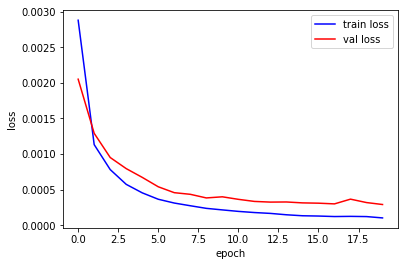

In [23]:
plt.plot(history.epoch,history.history['loss'], c='b', label='train loss')
plt.plot(history.epoch,history.history['val_loss'], c='r', label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Make predictions

In [24]:
time_train = np.arange(look_back,train_size+look_back)*dt
y_next_train_pred = model.predict(y_seq_train)

In [25]:
time_val = np.arange(look_back+train_size,look_back+train_size+1000)*dt
y_next_val_pred = model.predict(y_seq_val)

In [26]:
time_test = np.arange(look_back+train_size+1000,look_back+y_seq.shape[0])*dt
y_next_test_pred = model.predict(y_seq_test)

In [27]:
mean_squared_error(y_next_test, y_next_test_pred)

3.589361744124354e-05

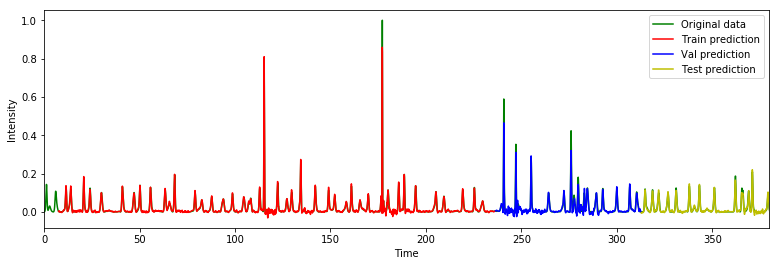

In [28]:
plt.figure(figsize=(13.0,4.0))
plt.plot(t, I, c='g', label='Original data')
plt.plot(time_train, y_next_train_pred, c='r', label='Train prediction')
plt.plot(time_val, y_next_val_pred, c='b', label='Val prediction')
plt.plot(time_test, y_next_test_pred, c='y', label='Test prediction')
plt.ylabel('Intensity')
plt.xlabel('Time')
plt.xlim([0,380])
plt.legend()
plt.show()

## Save the model

In [29]:
model.save('model.h5')
#model2 = load_model('model.h5')
#model2..predict(y_seq_test)